# Filtering and Coarse Graining 

### Filtering:
- Gaussian filter
- Box filter
- Spectral Filter

### Coarse graining 
- Spectral space

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.interpolate import RegularGridInterpolator

from py2d.initialize import initialize_wavenumbers_rfft2, gridgen
from py2d.convert import Omega2Psi
from py2d.spectra import spectrum_angled_average
from py2d.filter import filter2D

In [2]:
nx = 1024
filename = '../data/ICs/NX' + str(nx) + '/1.mat'
Lx = 2 * np.pi

NCoarse = 128
Delta = 2*Lx/NCoarse

filter_types = ['spectral-circle', 'spectral-square', 'gaussian', 'box']  # Define filter types


# load the data from the file
data = loadmat(filename)
# get the Omega data from the file
Omega = data['Omega']

def regrid(data, out_x, out_y):
    # Regrid data to a new grid size
    m = max(data.shape[0], data.shape[1])
    y = np.linspace(0, 1.0/m, data.shape[0])
    x = np.linspace(0, 1.0/m, data.shape[1])
    interpolating_function = RegularGridInterpolator((y, x), data)

    yv, xv = np.meshgrid(np.linspace(0, 1.0/m, out_y), np.linspace(0, 1.0/m, out_x))

    return interpolating_function((xv, yv))

if NCoarse % 2 == 0:
    N_DNS = nx
else:
    Omega = regrid(Omega, nx+1, nx+1)
    N_DNS = nx+1

Kx, Ky, Kabs, Ksq, invKsq = initialize_wavenumbers_rfft2(N_DNS, N_DNS, Lx, Lx, INDEXING='ij')

# calculate Psi from Omega using the Omega2Psi function
Psi = Omega2Psi(Omega, invKsq=invKsq)

# Calculating the spectrum of DNS data

# Calculate the absolute value of the Fourier transform of Omega
Omega_abs_hat = np.sqrt(np.fft.fft2(Omega)*np.conj(np.fft.fft2(Omega)))

# Calculate the spectrum using the spectrum_angled_average_ function
spectrum_angled_Omega, wavenumbers_angled_Omega = spectrum_angled_average(Omega_abs_hat, spectral=True)

### Filtering with/without Coarse Graining

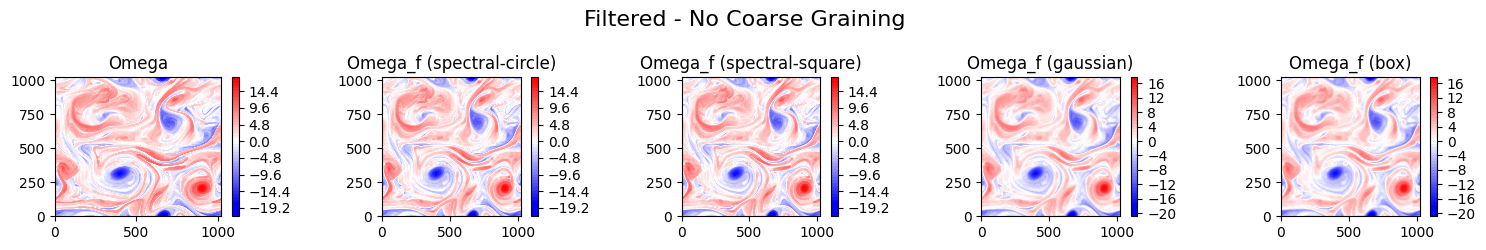

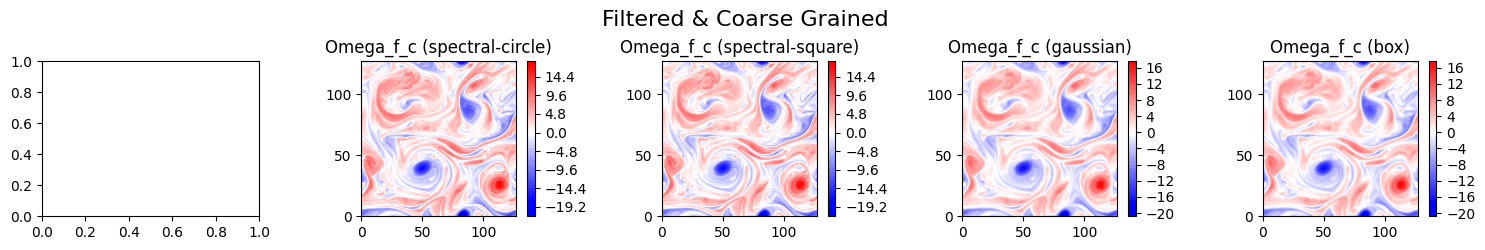

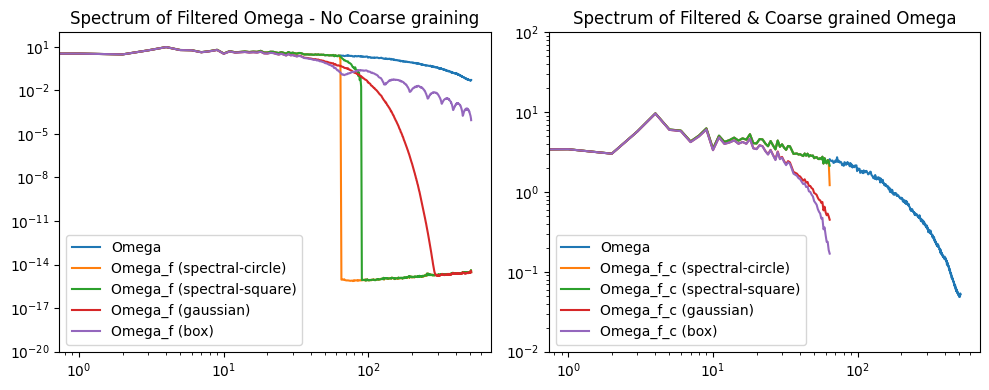

In [3]:
# Create a common colorbar range
vmax = Omega.max()
vmin = -vmax

# Initialize figure for contour
fig_contour, axs_contour = plt.subplots(1, len(filter_types) + 1, figsize=(15, 2.5))  # plus 1 for original Omega
fig_contour.suptitle('Filtered - No Coarse Graining', fontsize=16)

fig_contour_c, axs_contour_c = plt.subplots(1, len(filter_types) + 1, figsize=(15, 2.5))  # plus 1 for original Omega
fig_contour_c.suptitle('Filtered & Coarse Grained', fontsize=16)

# Initialize figure for spectrum
fig_spectrum, axs_spectrum = plt.subplots(nrows=1,ncols=2, figsize=(10, 4))

# Contour of original Omega
c = axs_contour[0].contourf(Omega, cmap='bwr', levels=50, vmax=vmax, vmin=vmin)
axs_contour[0].set_title('Omega')
fig_contour.colorbar(c, ax=axs_contour[0], orientation='vertical')

# Spectrum of Omega
axs_spectrum[0].loglog(wavenumbers_angled_Omega, spectrum_angled_Omega, label='Omega')
axs_spectrum[0].set_ylim([1e-20, 1e2])
axs_spectrum[1].loglog(wavenumbers_angled_Omega, spectrum_angled_Omega, label='Omega')
axs_spectrum[1].set_ylim([1e-2, 1e2])

kmax = 'grid'

# Contour and spectrum for each filter type
for i, filter_type in enumerate(filter_types):
    # Calculate filtered Omega
    Omega_f = filter2D(Omega, filterType=filter_type, coarseGrainType=None, Delta=Delta, Ngrid=np.ones(2)*NCoarse)
    Omega_f_c = filter2D(Omega, filterType=filter_type, coarseGrainType='spectral', Delta=Delta, Ngrid=np.ones(2)*NCoarse)

    # Contour of filtered Omega - No Coarse graining
    c1 = axs_contour[i + 1].contourf(Omega_f, cmap='bwr', levels=50, vmax=vmax, vmin=vmin)
    axs_contour[i + 1].set_title(f'Omega_f ({filter_type})')
    axs_contour[i + 1].set_aspect('equal')
    plt.colorbar(c1, ax=axs_contour[i + 1], orientation='vertical')

    # Contour of filtered Coarse grained Omega
    c2 = axs_contour_c[i + 1].contourf(Omega_f_c, cmap='bwr', levels=50, vmax=vmax, vmin=vmin)
    axs_contour_c[i + 1].set_title(f'Omega_f_c ({filter_type})')
    axs_contour_c[i + 1].set_aspect('equal')
    plt.colorbar(c2, ax=axs_contour_c[i + 1], orientation='vertical')

    # Calculate the absolute value of the Fourier transform of Omega_f and Omega_f_c
    Omega_f_abs_hat = np.sqrt(np.fft.fft2(Omega_f)*np.conj(np.fft.fft2(Omega_f)))
    Omega_f_c_abs_hat = np.sqrt(np.fft.fft2(Omega_f_c)*np.conj(np.fft.fft2(Omega_f_c)))

    # Calculate the spectrum using the spectrum_angled_average function
    spectrum_angled_Omega_f, wavenumbers_angled_Omega_f = spectrum_angled_average(Omega_f_abs_hat, spectral=True, kmax=kmax)
    spectrum_angled_Omega_f_c, wavenumbers_angled_Omega_f_c = spectrum_angled_average(Omega_f_c_abs_hat, spectral=True, kmax=kmax)

    # Spectrum of filtered (Coarse-grained) Omega
    axs_spectrum[0].loglog(wavenumbers_angled_Omega_f, spectrum_angled_Omega_f, label=f'Omega_f ({filter_type})')
    axs_spectrum[1].loglog(wavenumbers_angled_Omega_f_c, spectrum_angled_Omega_f_c, label=f'Omega_f_c ({filter_type})')

    # axs_spectrum[0].axvline(x=NCoarse/2, color='red', linestyle='--')
    # axs_spectrum[1].axvline(x=NCoarse/2, color='red', linestyle='--')

# Set title and legend for spectrum plot
axs_spectrum[0].set_title('Spectrum of Filtered Omega - No Coarse graining')
axs_spectrum[0].legend()
axs_spectrum[1].set_title('Spectrum of Filtered & Coarse grained Omega')
axs_spectrum[1].legend()

# Layout adjustment
fig_contour.tight_layout()
fig_contour_c.tight_layout()
fig_spectrum.tight_layout()

# Display plots
plt.show()


### Compare JAX and numpy coarse graining codes

Max Difference between numpy and JAX coarse grained data 1.4210854715202004e-14
Testing if coarse grained JAX and numpy outputs are the same:  True
Max difference between numpy and JAX coarse grained spectra 3.552713678800501e-15


(0.01, 50.0)

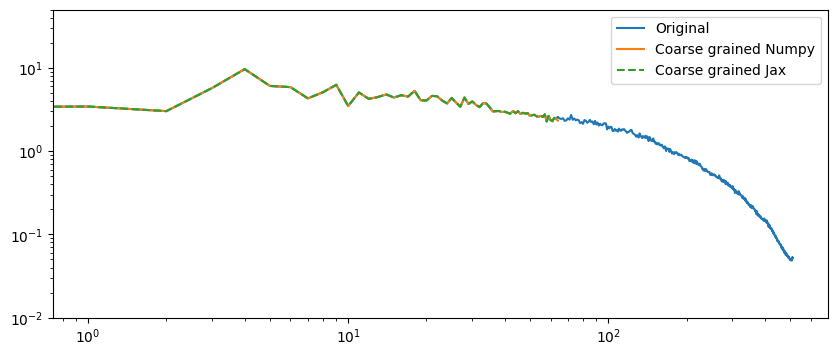

In [4]:
# Testing coarse graining code # Comparing the outputs of JAX and numpy
from py2d.filter import coarse_spectral_filter_square
from py2d.filter import coarse_spectral_filter_square_jit
from py2d.spectra import spectrum_angled_average

import jax
import jax.numpy as jnp

import numpy as np

jax.config.update('jax_enable_x64', True)

Ngrid = Omega.shape[0]
a = Omega.copy()
a_jit = jnp.asarray(a)
# NCoarse = 128


a_temp = coarse_spectral_filter_square(np.fft.rfft2(a), NCoarse)
a_coarse_jit_temp = coarse_spectral_filter_square_jit(jnp.fft.rfft2(a_jit), NCoarse)

a_coarse = np.fft.irfft2(a_temp, s=[NCoarse, NCoarse])
a_coarse_jit_temp2 = jnp.fft.irfft2(a_coarse_jit_temp, s=[NCoarse, NCoarse])
a_coarse_jit = np.asarray(a_coarse_jit_temp2)

print('Max Difference between numpy and JAX coarse grained data', np.max(np.abs(a_coarse - a_coarse_jit)))
print("Testing if coarse grained JAX and numpy outputs are the same: ", np.allclose((a_coarse_jit), a_coarse))

a_spectral, ka = spectrum_angled_average(np.sqrt(np.fft.fft2(a)*np.conj(np.fft.fft2(a))), spectral=True)
a_coarse_spectral, ka_coarse = spectrum_angled_average(np.sqrt(np.fft.fft2(a_coarse)*np.conj(np.fft.fft2(a_coarse))), spectral=True)
a_coarse_spectral_jit, ka_coarse_jit = spectrum_angled_average(np.sqrt(np.fft.fft2(a_coarse_jit)*np.conj(np.fft.fft2(a_coarse_jit))), spectral=True)

print('Max difference between numpy and JAX coarse grained spectra', np.max(np.abs(a_coarse_spectral - a_coarse_spectral_jit)))
fig, axs = plt.subplots(1, 1, figsize=(10, 4))
axs.loglog(ka, a_spectral, label='Original')
axs.loglog(ka_coarse, a_coarse_spectral, label='Coarse grained Numpy')
axs.loglog(ka_coarse_jit, a_coarse_spectral_jit, '--', label='Coarse grained Jax')
# show labels
axs.legend()
axs.set_ylim([1e-2, 5e1])

In [5]:
## Comparing numpy and JAX coarse graining functions

N = 16
Nc = 8

temp = np.random.rand(N, N)

temp_coarse_hat = coarse_spectral_filter_square(np.fft.rfft2(temp), Nc)
temp_coarse_jit_hat = coarse_spectral_filter_square_jit(jnp.fft.rfft2(temp), Nc)


print('Max difference between JAX and numpy coarse grained data', np.max(np.abs(temp_coarse_hat-temp_coarse_jit_hat)))


Max difference between JAX and numpy coarse grained data 1.2658490090568385e-15
